# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduce the amount of coding that would be needed when interacting with Google API

In [ ]:
# First check if running on Google Colab
try:
    from google.colab import drive

    # Install required packages
    ! pip install pandarallel
    ! pip install opencv-python

    # Mount Drive
    drive.mount("/content/gdrive", force_remount=True)

    IN_COLAB = True
    file_placement = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data"
except:
    IN_COLAB = False

    # Install required packages
    ! pip install opencv-python

    import os
    file_placement = os.path.join(os.getcwd(), "..", "data")
print("running in colab?", IN_COLAB, "\ndata files:", file_placement)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.3 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=3fe48286fdc0c08710a51405a619c83b3ee53d59a17d016f38d740b6f719e2c8
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/gdrive
running in colab? True 
data files: /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data


In [ ]:
import os
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import pandas as pd

if IN_COLAB:
    base_folder = os.path.join(file_placement, "..", "..", "Publishing")
else:
    base_folder = os.path.join(file_placement, "..")
train_and_test = pd.read_excel(os.path.join(base_folder, "train_and_test_set.xlsx"))

In the next code blocks we experimented (or simulated) how PyTorch would do for augmentation. We didn't use PyTorch for this exploration because it augments in real time, when iterating over a batch, not keeping tabs on the transformations applied.

In [ ]:
import numpy as np
import cv2

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

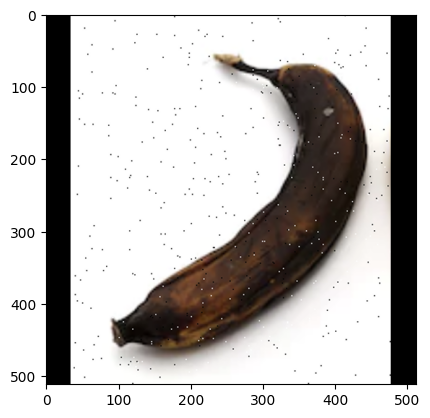

-90


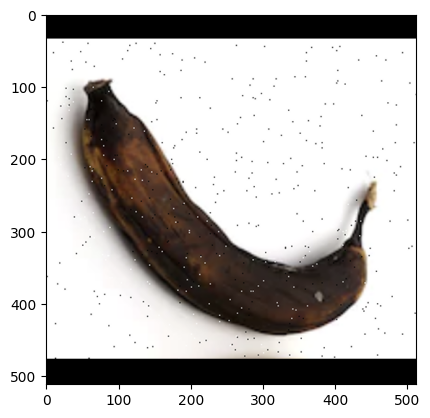

-60


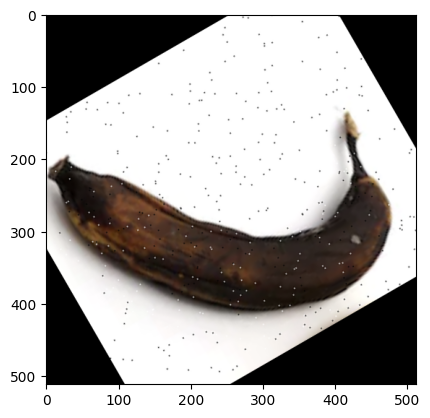

-45


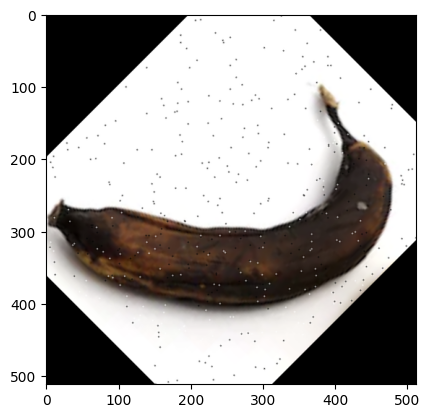

45


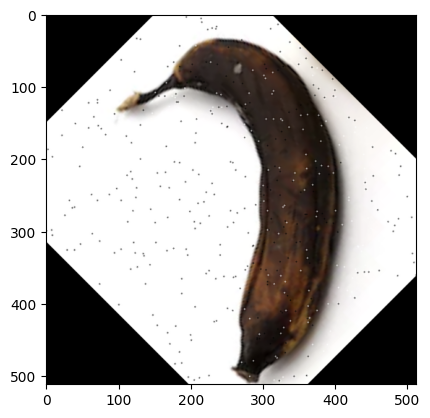

60


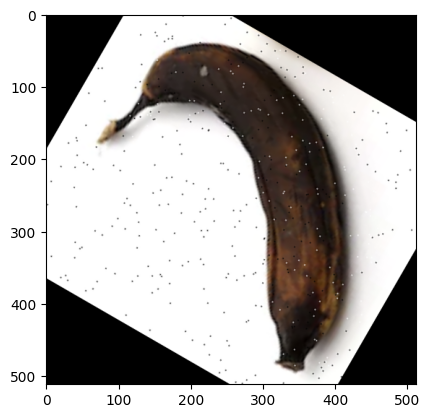

90


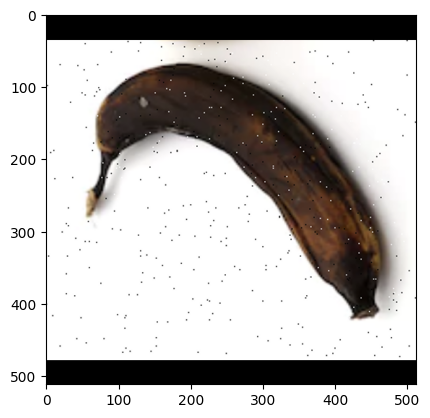

flippling vertically


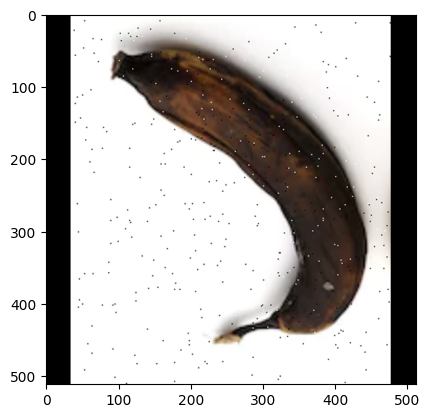

flippling horizontally


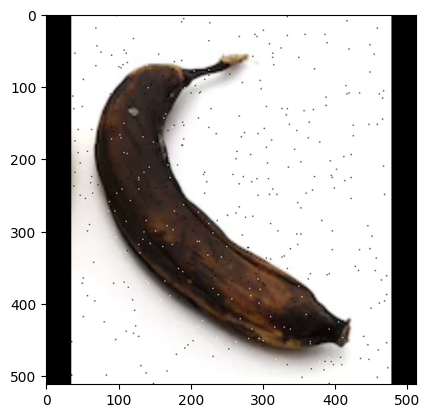

In [ ]:
sample_max_width = (train_and_test[train_and_test["fresh"] == False]).sample(n=1)

image_path = sample_max_width.iloc[0]["path"]

not_fresh_path = os.path.join(base_folder, "transformed_images", "notfresh")
fresh_path = os.path.join(base_folder, "transformed_images", "fresh")

is_fresh = sample_max_width["fresh"].values
if is_fresh == True:
    new_placement = os.path.join(fresh_path, os.path.basename(image_path))
else:
    new_placement = os.path.join(not_fresh_path, os.path.basename(image_path))

image = cv2.imread(new_placement)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()
for each_degree in [-90, -60, -45, 45, 60, 90]:
    image_rotated = rotate_image(image,each_degree)
    print(each_degree)
    plt.imshow(image_rotated)
    plt.show()

image_flipped = cv2.flip(image, 0)
print("flippling vertically")
plt.imshow(image_flipped)
plt.show()

image_flipped = cv2.flip(image, 1)
print("flippling horizontally")
plt.imshow(image_flipped)
plt.show()

Now we finally tested how the augmentation would work on PyTorch

In [ ]:
data_folder = os.path.join(base_folder, "transformed_images")
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(data_folder, transform=transform)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, drop_last=True)
images, labels = next(iter(dataloader))


In [ ]:
transform =  transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)
dataset_augmented = datasets.ImageFolder(data_folder, transform=transform)
dataloader_augmented = torch.utils.data.DataLoader(dataset_augmented, batch_size=64, shuffle=False, drop_last=True)
images_augmented, labels_augmented = next(iter(dataloader_augmented))

<ipython-input-4-cc04b8c21a5f>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


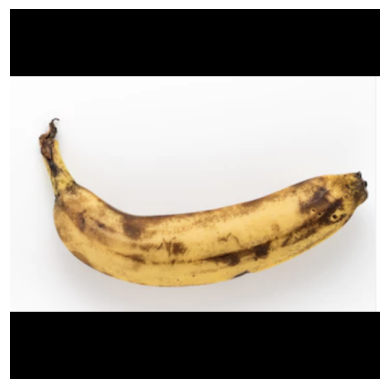

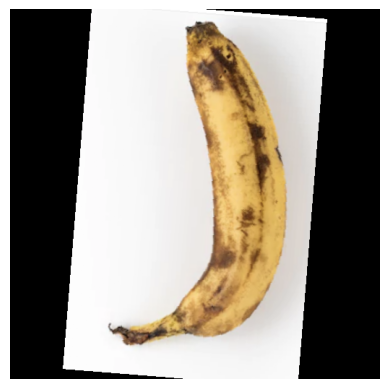

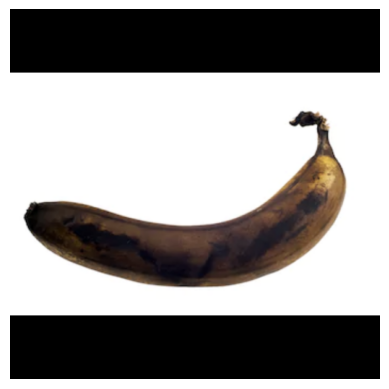

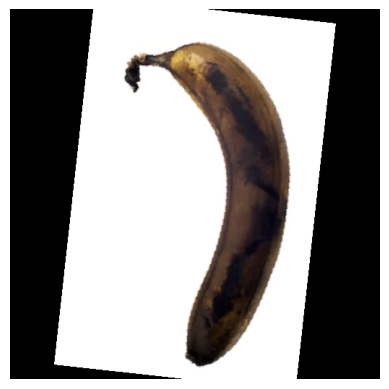

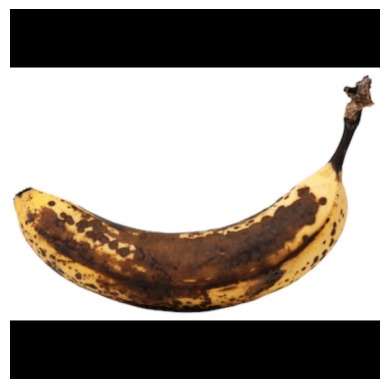

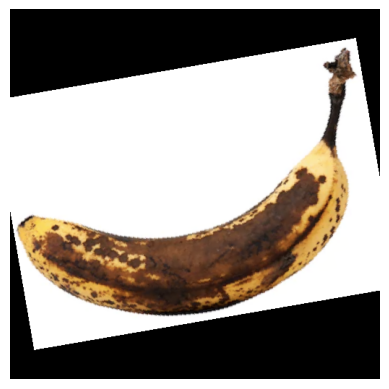

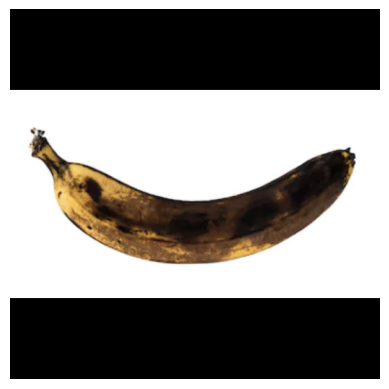

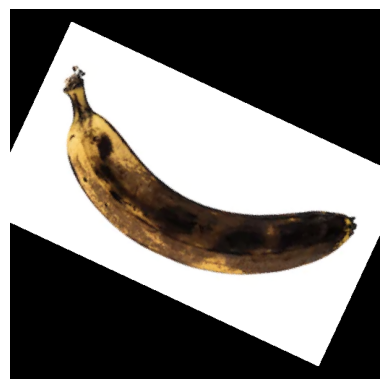

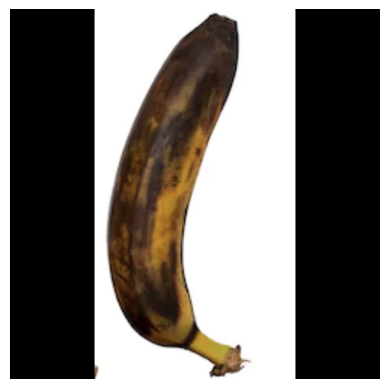

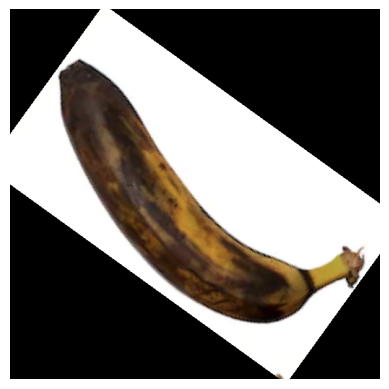

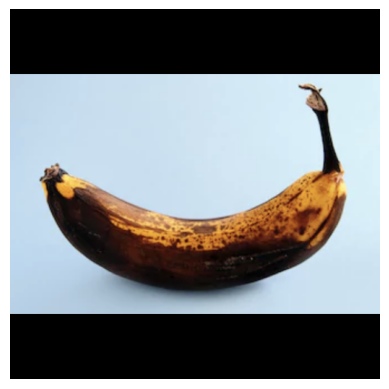

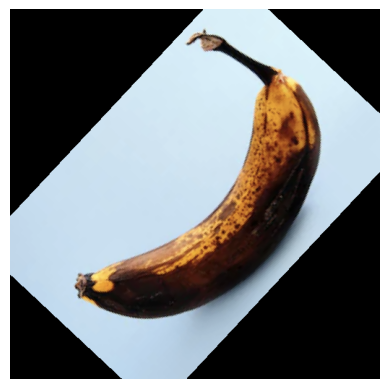

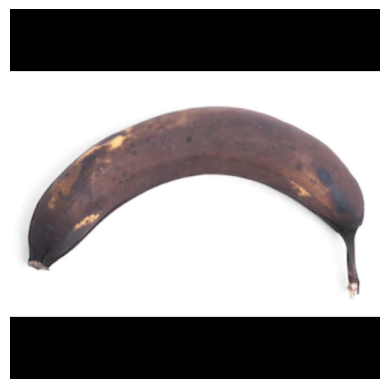

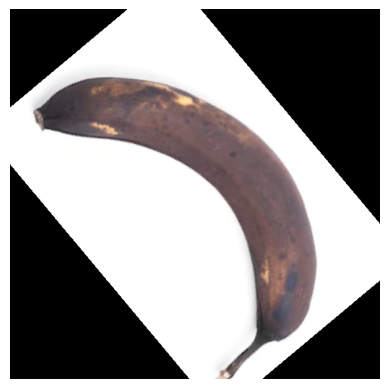

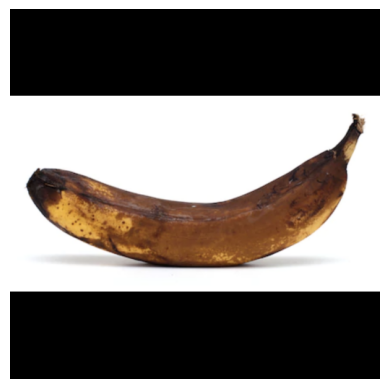

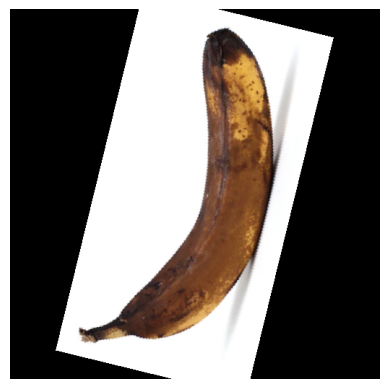

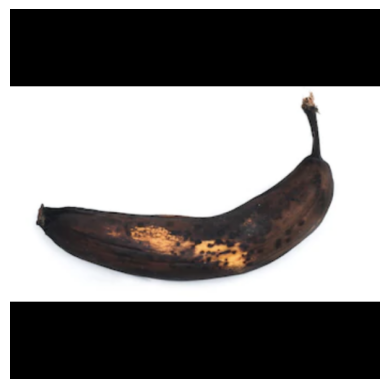

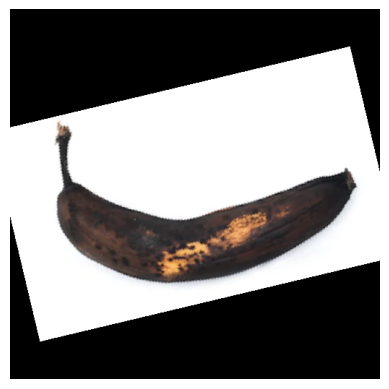

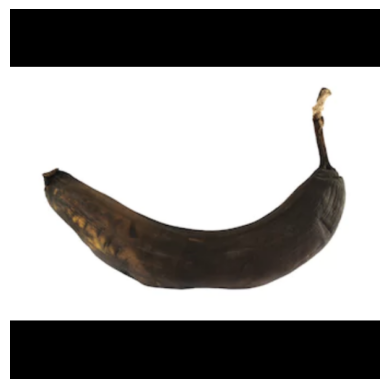

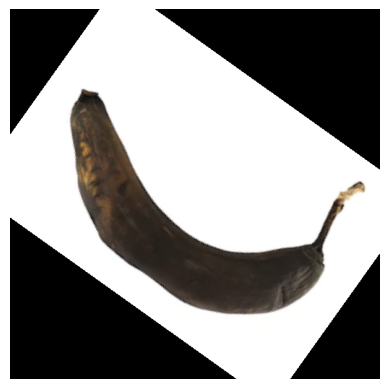

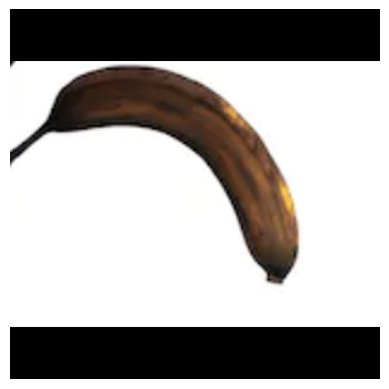

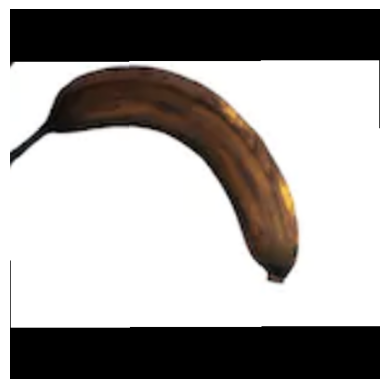

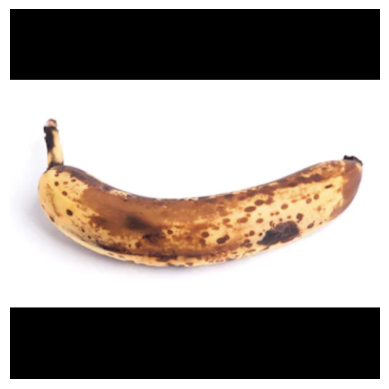

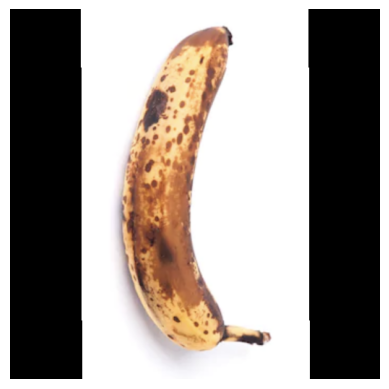

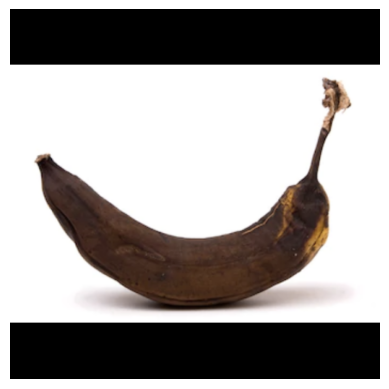

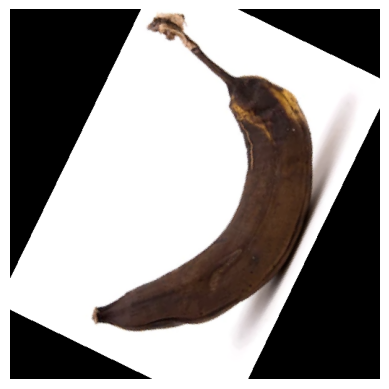

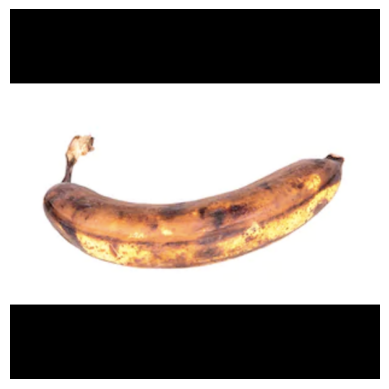

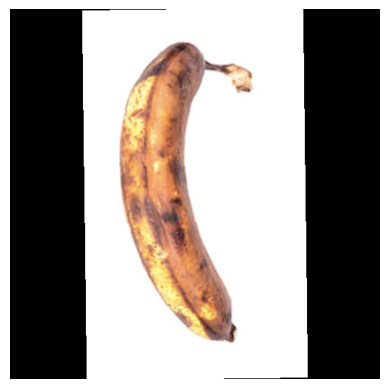

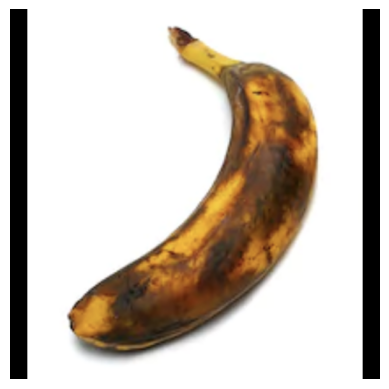

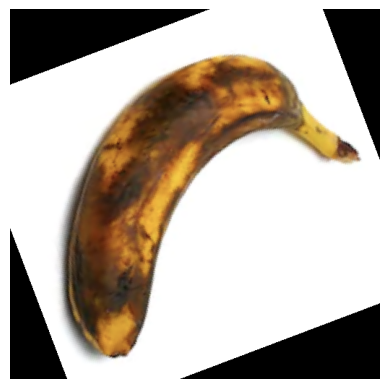

In [ ]:
images, labels = next(iter(dataloader))
images_augmented, labels_augmented = next(iter(dataloader_augmented))
for i in range(15):
    # if labels[i] == 1:
    imshow(images[i], normalize=False)
    imshow(images_augmented[i], normalize=False)